# Speech Emotion Recognition - Dataset Preparation, EDA, and Preprocessing

## 1. Setup and Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Basic paths defined
import os
DRIVE_ROOT = '/content/drive/MyDrive/emotion_recognition_project'
os.makedirs(DRIVE_ROOT, exist_ok=True)

# KaggleHub setup
os.environ["KAGGLEHUB_CACHE"] = f"{DRIVE_ROOT}/kagglehub_cache"

In [ ]:
# Import libraries
import kagglehub
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import soundfile as sf

In [ ]:
!pip install -q kagglehub

## 2. Dataset Preparation

In this project, we combine four well-known emotional speech datasets:
1. **SAVEE**: Surrey Audio-Visual Expressed Emotion   
2. **RAVDESS**: Ryerson Audio-Visual Database of Emotional Speech and Song   
3. **CREMA-D**: Crowd-Sourced Emotional Multimodal Actors Dataset
4. **TESS**: Toronto Emotional Speech Set

These datasets include speech samples labeled with human emotions such as *happy*, *sad*, *angry*, and more.

Before using them, we inspect, clean, and standardize the labels to build a single consistent dataset ready for training and evaluation.

In [ ]:
# Download datasets via KaggleHub
SAVEE = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")
RAV = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
CREMAD = kagglehub.dataset_download("ejlok1/cremad")
TESS = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

## 3. Dataset Processing and Merging

### 3.1 Surrey Audio-Visual Expressed Emotion Dataset (SAVEE)

In [ ]:
# See how raw SAVEE filenames encode emotions
SAVEE_PATH = os.path.join(SAVEE, 'ALL')
sample_files = os.listdir(SAVEE_PATH)[:10]
print("Example raw SAVEE filenames:\n")
for f in sample_files:
    print(f)

The SAVEE dataset stores emotion labels inside the filenames.

For example:

- DC_a01.wav → "angry" (_a)

- JK_d03.wav → "disgust" (_d)

The filenames we found use short emotion codes instead of full labels. So, We manually map these short codes to proper emotion names *(e.g., _a → "angry")* to make the dataset understandable for model training.

In [ ]:
# Process SAVEE
SAVEE_PATH = os.path.join(SAVEE, 'ALL')
emotion = []
path = []
for i in os.listdir(SAVEE_PATH):
    code = i[-8:-6]
    if code == '_a':
        emotion.append('angry')
    elif code == '_d':
        emotion.append('disgust')
    elif code == '_f':
        emotion.append('fear')
    elif code == '_h':
        emotion.append('happy')
    elif code == '_n':
        emotion.append('neutral')
    elif code == 'sa':
        emotion.append('sad')
    elif code == 'su':
        emotion.append('surprise')
    else:
        emotion.append('error')
    path.append(os.path.join(SAVEE_PATH, i))
SAVEE_df = pd.DataFrame({"label": emotion, "path": path, "source": "SAVEE"})
SAVEE_df.head()

,label,path,source
0,happy,/kaggle/input/surrey-audiovisual-expressed-emo...,SAVEE
1,fear,/kaggle/input/surrey-audiovisual-expressed-emo...,SAVEE
2,happy,/kaggle/input/surrey-audiovisual-expressed-emo...,SAVEE
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emo...,SAVEE
4,angry,/kaggle/input/surrey-audiovisual-expressed-emo...,SAVEE


## 3.2 Ryerson Audio-Visual Database of Emotional Speech and Song Dataset(RAVDESS)

In [ ]:
# See some raw filenames in RAVDESS
sample_files = []
for folder in os.listdir(RAV):
    if "Actor" not in folder:
        continue
    folder_path = os.path.join(RAV, folder)
    sample_files.extend(os.listdir(folder_path)[:3])
print("Example raw RAVDESS filenames:\n")
for f in sample_files:
    print(f)

The RAVDESS dataset stores emotions as part of the filename itself.
Example filename: 03-01-05-01-01-01-01.wav

The 3rd number (05) corresponds to the emotion:

- 01 = Neutral
- 03 = Happy
- 04 = Sad
- 05 = Angry
- 06 = Fearful
- 07 = Disgust
- 08 = Surprised

The Emotion classes are stored as numeric codes in filenames.So We extracted the emotion number from the filename and map it to a readable emotion label.

In [ ]:
# Process RAVDESS
emotion_dict = {
    1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}
emotions = []
paths = []
for folder in os.listdir(RAV):
    if "Actor" not in folder:
        continue
    folder_path = os.path.join(RAV, folder)
    for file in os.listdir(folder_path):
        emo_code = int(file[6:8])
        emotions.append(emotion_dict.get(emo_code, "unknown"))
        paths.append(os.path.join(folder_path, file))
RAV_df = pd.DataFrame({"label": emotions, "path": paths, "source": "RAVDESS"})
RAV_df.head()

,label,path,source
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/A...,RAVDESS
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/A...,RAVDESS
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/A...,RAVDESS
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/A...,RAVDESS
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/A...,RAVDESS


## 3.3 Crowd Sourced Emotional Multimodal Actors Dataset (CREAMA-D)

In [ ]:
# See some raw filenames in CREMA-D
sample_files = []
for folder in os.listdir(CREMAD):
    folder_path = os.path.join(CREMAD, folder)
    sample_files.extend(os.listdir(folder_path)[:3])
print("Example raw CREMA-D filenames:\n"
for f in sample_files:
    print(f)

The CREMA-D dataset also encodes emotion information into the filenames.
Example filename: 1001_IEO_AWL.wav

The 3 letters (e.g., IEO) represent emotions:

- ANG = Angry
- DIS = Disgust
- FEA = Fear
- HAP = Happy
- NEU = Neutral
- SAD = Sad

In this case, Emotions are stored as three-letter codes hidden inside the filename. So we extracted the 3-letter emotion code and map it to its full emotion label.

In [ ]:
# Process CREMA-D
emotion_dict = {
    "ANG": "angry", "DIS": "disgust", "FEA": "fear",
    "HAP": "happy", "NEU": "neutral", "SAD": "sad"

}
emotions = []
paths = []
for folder in os.listdir(CREMAD):
    folder_path = os.path.join(CREMAD, folder)
    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            emo_code = file[9:12]
            emotions.append(emotion_dict.get(emo_code, "unknown"))
            paths.append(os.path.join(folder_path, file))
CREMA_df = pd.DataFrame({"label": emotions, "path": paths, "source": "CREMA-D"})
CREMA_df.head()

,label,path,source
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav,CREMA-D
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav,CREMA-D
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav,CREMA-D
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav,CREMA-D
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav,CREMA-D


## 3.4 Toronto emotional speech set Dataset (TESS)

In [ ]:
sample_folders = os.listdir(TESS)
print("Example raw TESS folders:\n")
for folder in sample_folders:
    print(folder

The TESS dataset is organized in folders.
Each folder name already contains the emotion (e.g., "Angry", "Happy", ...)

- Folder examples: OAF_angry, YAF_happy

Inside each folder are .wav files related to that emotion. In this case, the emotion is not in the filename, but in the folder name. Therefore, We used the folder name to infer the emotion for each audio file.

In [ ]:
# Process TESS
TESS_path = os.path.join(TESS, "TESS Toronto emotional speech set data")
emotion = []
path = []
for i in os.listdir(TESS_path):
    folder_path = os.path.join(TESS_path, i)
    for f in os.listdir(folder_path):
        folder_lower = i.lower()
        if 'angry' in folder_lower:
            emotion.append('angry')
        elif 'disgust' in folder_lower:
            emotion.append('disgust')
        elif 'fear' in folder_lower:
            emotion.append('fear')
        elif 'happy' in folder_lower:
            emotion.append('happy')
        elif 'neutral' in folder_lower:
            emotion.append('neutral')
        elif 'surprise' in folder_lower:
            emotion.append('surprise')
        elif 'sad' in folder_lower:
            emotion.append('sad')
        else:
            emotion.append('unknown')
        path.append(os.path.join(folder_path, f))
TESS_df = pd.DataFrame({"label": emotion, "path": path, "source": "TESS"})
TESS_df.head()

,label,path,source
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...,TESS
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...,TESS
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...,TESS
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...,TESS
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...,TESS


## 3.5 Merging SAVEE, RAV, CREMA-D, TESS

We merge all the datasets together to form a complete metadata-like dataset which is standardised

In [ ]:
# Merge all datasets together
all_df = pd.concat([SAVEE_df, RAV_df, CREMA_df, TESS_df], ignore_index=True)
all_df.tail()

,label,path,source
12157,surprise,/kaggle/input/toronto-emotional-speech-set-tes...,TESS
12158,surprise,/kaggle/input/toronto-emotional-speech-set-tes...,TESS
12159,surprise,/kaggle/input/toronto-emotional-speech-set-tes...,TESS
12160,surprise,/kaggle/input/toronto-emotional-speech-set-tes...,TESS
12161,surprise,/kaggle/input/toronto-emotional-speech-set-tes...,TESS


In [ ]:
# Save CSV in Drive
csv_output_path = os.path.join(DRIVE_ROOT, "emotion_colab_all.csv")
all_df.to_csv(csv_output_path, index=False)
print(f"CSV saved to: {csv_output_path}")

CSV saved to: /content/drive/MyDrive/emotion_recognition_project/emotion_colab_all.csv


In [ ]:
print(all_df.head(3))
print(all_df['label'].unique())

   label                                               path source
0  happy  /kaggle/input/surrey-audiovisual-expressed-emo...  SAVEE
1   fear  /kaggle/input/surrey-audiovisual-expressed-emo...  SAVEE
2  happy  /kaggle/input/surrey-audiovisual-expressed-emo...  SAVEE
['happy' 'fear' 'disgust' 'angry' 'surprise' 'neutral' 'sad']


## Exploratory Data Analysis (Duration - Sample rate - Zero Crossings)

In [ ]:
# Load metadata (merged dataset)
metadata_path = "/content/drive/MyDrive/emotion_recognition_project/emotion_colab_all.csv"
df_all = pd.read_csv(metadata_path)

# Storage for features
durations = []
sample_rates = []
zero_crossings = []
rms_energy = []
failed_paths = []

# Process each file
for i, row in df_all.iterrows():
    try:
        y, sr = librosa.load(row['path'], sr=None)
        durations.append(len(y) / sr) # append the track duration
        sample_rates.append(sr) # append the track sample rate (very important for the Wav2Vec2 -> needs fixed sample rate)
        zero_crossings.append(((y[:-1] * y[1:]) < 0).sum()) # number of times the track signal crosses 0
        rms_energy.append(librosa.feature.rms(y=y).mean()) # avg loudness of the track using Root Mean Sqr
    except Exception as e:
        durations.append(None)
        sample_rates.append(None)
        zero_crossings.append(None)
        rms_energy.append(None)
        failed_paths.append(row['path'])

# Add features to the DataFrame
df_all['duration_sec'] = durations
df_all['sample_rate'] = sample_rates
df_all['zero_crossings'] = zero_crossings
df_all['rms_energy'] = rms_energy

# Remove failed entries
df_analyzed = df_all.dropna(subset=['duration_sec'])

# Save results separately => New complete dataset with added features [duration_sec, sample_rate, zero_crossings, rms_energy]
analyzed_path = "/content/drive/MyDrive/emotion_recognition_project/analyzed_metadata.csv"
df_analyzed.to_csv(analyzed_path, index=False)

failed_path_log = "/content/drive/MyDrive/emotion_recognition_project/failed_audio_paths.txt"
with open(failed_path_log, "w") as f:
    for path in failed_paths:
        f.write(path + "\n")

# Summary (check for any failures)
total_files = len(df_all)
successful_files = len(df_analyzed)
failed_files = total_files - successful_files
failure_rate = (failed_files / total_files) * 100

print(f"Successfully analyzed: {successful_files}/{total_files} files")
print(f"Failed to analyze: {failed_files} files ({failure_rate:.2f}%)")
print(f"Cleaned data saved to: {analyzed_path}")
print(f"Failed file paths saved to: {failed_path_log}")

Successfully analyzed: 12162/12162 files
Failed to analyze: 0 files (0.00%)
Cleaned data saved to: /content/drive/MyDrive/emotion_recognition_project/analyzed_metadata.csv
Failed file paths saved to: /content/drive/MyDrive/emotion_recognition_project/failed_audio_paths.txt


# EDA and Analysis of the dataset

In [ ]:
metadata_path = "/content/drive/MyDrive/emotion_recognition_project/analyzed_metadata.csv"
df = pd.read_csv(metadata_path)

## Duration Distribution

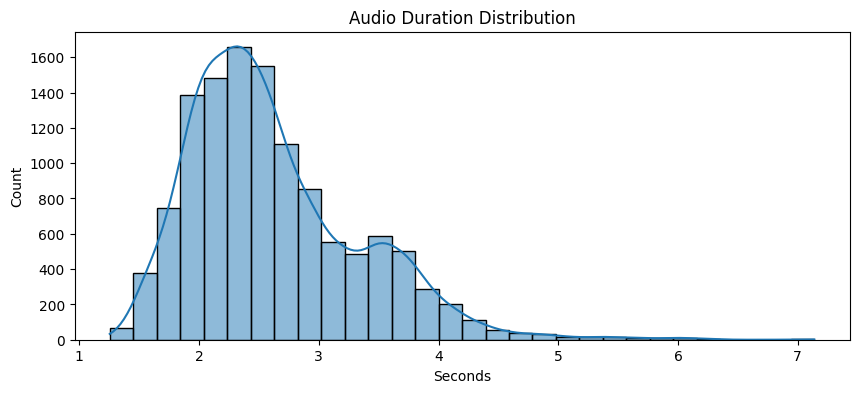

In [ ]:
# Duration distribution
plt.figure(figsize=(10, 4))
sns.histplot(df['duration_sec'], bins=30, kde=True)
plt.title('Audio Duration Distribution')
plt.xlabel('Seconds')
plt.ylabel('Count')
plt.show()

### Audio Duration Distribution

This histogram shows the distribution of audio clip durations in seconds. Most recordings are between 2 and 3 seconds long, with a peak near 2.4–2.5 seconds. The distribution is right-skewed, meaning there are fewer longer clips beyond 4 seconds. Based on this, extracting the first 4 seconds after and offsetting it by 0.5 from each clip would retain over 90% of the data while standardizing input lengths for model training.

## Emotion Distribution

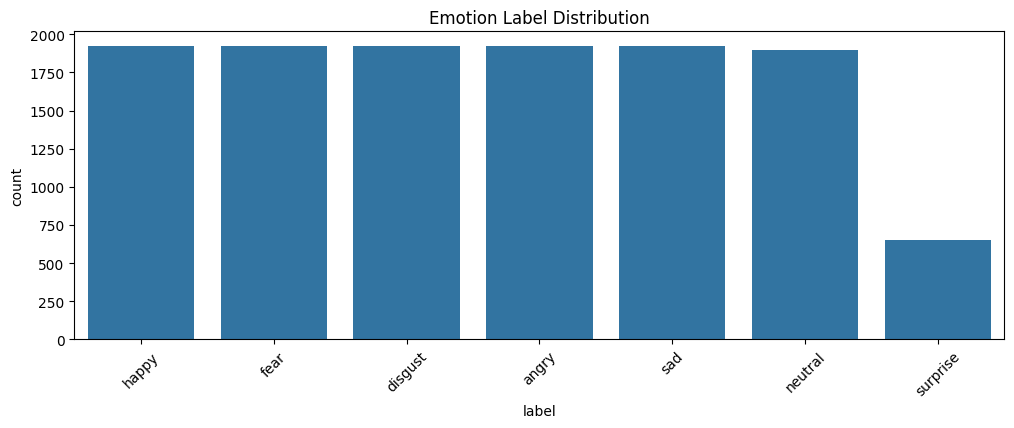

In [ ]:
# Emotion distribution
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='label', order=df_analyzed['label'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Emotion Label Distribution')
plt.show()

### Emotion Label Distribution

This bar chart displays the distribution of emotion labels in the dataset. Most emotion classes—`happy`, `fear`, `disgust`, `angry`, `sad`, and `neutral`—are nearly balanced, each with around 1900 samples. The `surprise` category, however, is noticeably underrepresented with fewer than 700 instances. Despite its low frequency, `surprise` might still be relatively easy to classify due to its distinctive acoustic characteristics, such as high pitch and tonality, which make it stand out from other emotions.

## Sample Rate Distribution

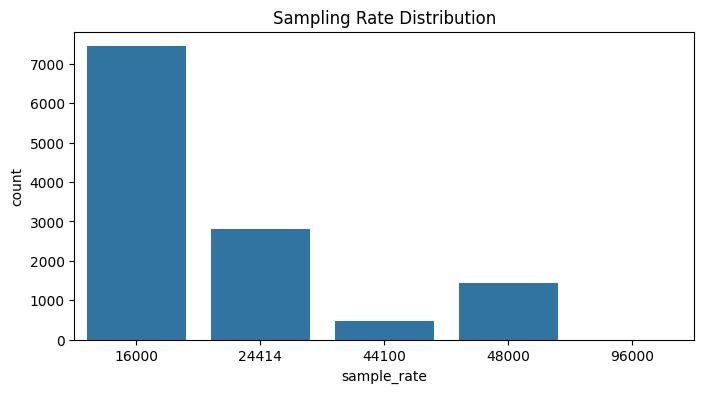

In [ ]:
# Sample rate check
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='sample_rate')
plt.title('Sampling Rate Distribution')
plt.show()


### Sampling Rate Distribution

This bar chart shows the distribution of sampling rates across the audio clips in the dataset. The majority of samples were recorded at 16,000 Hz, which is a common standard in speech processing. Other sample rates such as 24,414 Hz, 44,100 Hz, and 48,000 Hz appear less frequently, with very few samples at 96,000 Hz. This variability suggests that resampling will be necessary to ensure consistency in model input, ideally standardizing all clips to 16,000 Hz for compatibility with most pretrained speech models like Wav2Vec2.

## Duration per emotion

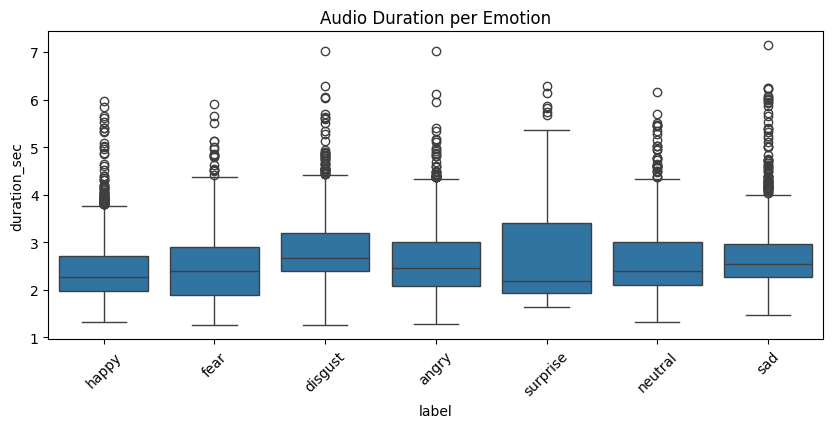

In [ ]:
# Duration per emotion (mean)
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='label', y='duration_sec')
plt.xticks(rotation=45)
plt.title('Audio Duration per Emotion')
plt.show()


### Audio Duration per Emotion

This boxplot illustrates the distribution of audio durations across different emotion labels. Most emotions show a similar range of durations, centered around 2.5 to 3 seconds, but with notable variability and outliers. The `surprise` category stands out with a wider spread and a higher number of longer clips, suggesting greater variability in how that emotion is expressed. Despite its lower sample count, `surprise` also exhibits longer average durations compared to other emotions, which could provide richer acoustic features for classification.

## Energy per emotion (rough quality indicator)

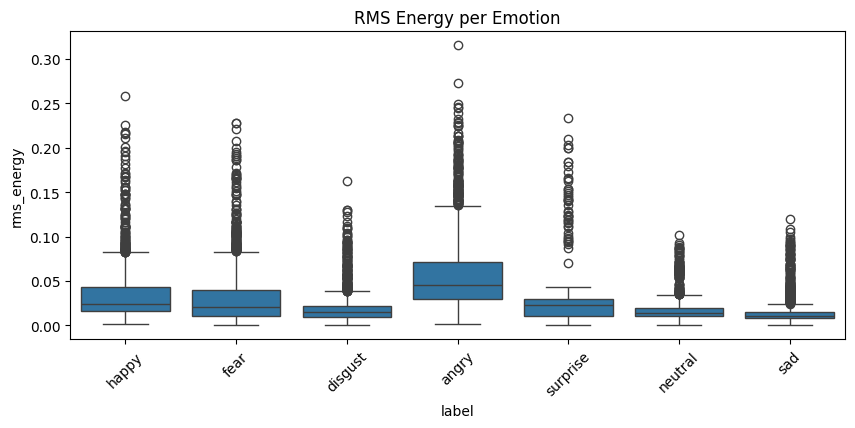

In [ ]:
# Energy per emotion (rough quality indicator) Interesting
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='label', y='rms_energy')
plt.xticks(rotation=45)
plt.title('RMS Energy per Emotion')
plt.show()

### RMS Energy per Emotion

This boxplot shows the Root Mean Square (RMS) energy distribution across different emotion categories. RMS energy serves as a rough proxy for the perceived loudness or intensity of a signal. As expected, `angry` recordings tend to have the highest median energy and the largest variance, reflecting the naturally louder expression of that emotion. `Surprise` also exhibits relatively high variability. In contrast, `neutral` and `sad` emotions are generally associated with lower and more consistent energy levels.

# Audio Preprocessing and Standardization

To ensure consistency across all audio inputs for model training, we preprocess each audio file using the following pipeline:

- **Input Metadata**: We load a CSV file containing the metadata for all audio samples, including their original file paths.
- **Target Configuration**:
  - **Sampling Rate**: All audio files are resampled to 16 kHz for compatibility with most deep learning audio models.
  - **Duration**: Each clip is trimmed or padded to exactly 4 seconds, starting from a 0.5 second offset to skip initial silence or irrelevant noise.
- **Processing Logic**:
  - Audio is loaded using `librosa`, cropped or zero-padded to maintain a fixed length, and then saved using `soundfile` to a new directory.
  - The original filename is preserved, and the new path is stored.
  - Any files that fail to load or process are flagged and excluded from the final metadata.

- **Output**:
  - A cleaned metadata CSV is generated, containing only successfully processed files and their new paths.
  - This ensures downstream models work with uniformly formatted and high-quality input data.

This step is critical for maintaining dataset integrity and making sure all samples are of equal length and sample rate, which simplifies batching and avoids unnecessary preprocessing at training time for all the methods we have implemented.

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
from tqdm import tqdm

# Configuration
INPUT_METADATA = "/content/drive/MyDrive/emotion_recognition_project/analyzed_metadata.csv"
OUTPUT_DIR = "/content/drive/MyDrive/emotion_recognition_project/processed_audio_16k_4s"
OUTPUT_CSV = "/content/drive/MyDrive/emotion_recognition_project/processed_metadata.csv" # Final path of the metadata for the extraction!!

SAMPLE_RATE = 16000
DURATION = 4.0
OFFSET = 0.5
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load the analysed metadata
df = pd.read_csv(INPUT_METADATA)

# processing files
processed_paths = []
success_flags = []

def process_and_save_audio(path, filename):
    try:
        y, _ = librosa.load(path, sr=SAMPLE_RATE, offset=OFFSET, duration=DURATION)

        # Ensure fixed length (pad or crop)
        target_len = int(SAMPLE_RATE * DURATION)
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        else:
            y = y[:target_len]

        out_path = os.path.join(OUTPUT_DIR, filename)
        sf.write(out_path, y, SAMPLE_RATE)
        return out_path, True
    except Exception as e:
        return None, False

for _, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row['path']
    filename = os.path.basename(file_path)
    out_path, success = process_and_save_audio(file_path, filename)
    processed_paths.append(out_path)
    success_flags.append(success)

# Update and save the metadata
df['processed_path'] = processed_paths
df['processed_success'] = success_flags
df_cleaned = df[df['processed_success'] == True].copy()

df_cleaned.to_csv(OUTPUT_CSV, index=False)
print(f"Saved cleaned metadata to: {OUTPUT_CSV}")
print(f"Total successful files: {len(df_cleaned)} / {len(df)}")


100%|██████████| 12162/12162 [3:04:07<00:00,  1.10it/s]


Saved cleaned metadata to: /content/drive/MyDrive/emotion_recognition_project/processed_metadata.csv
Total successful files: 12162 / 12162
